In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline
sns.set()

In [2]:
data=pd.read_csv('Amsterdam_AirBnB_Listings.csv')

In [3]:
data.head(5)

,listing_id,date
0,2818,2009-03-30
1,2818,2009-04-24
2,2818,2009-05-03
3,2818,2009-05-18
4,2818,2009-05-25


In [4]:
data.set_index('date',inplace=True)

In [5]:
data_new=data.groupby(by='date').agg({'listing_id' : 'count'})

In [6]:
data_new.shape

(3008, 1)

In [7]:
data_new.index=pd.to_datetime(data_new.index)

In [8]:
data_new=data_new.asfreq('1D')
data_new.fillna(0,inplace=True)

In [9]:
data_new=data_new.sort_index(ascending=True)

In [10]:
data_new['ts']=data_new['listing_id']
data_new.drop(columns='listing_id',inplace=True)
data_new.tail(10)

,ts
date,
2019-04-27,261.0
2019-04-28,715.0
2019-04-29,423.0
2019-04-30,312.0
2019-05-01,289.0
2019-05-02,178.0
2019-05-03,227.0
2019-05-04,227.0
2019-05-05,395.0


C:\Users\ACER M5\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


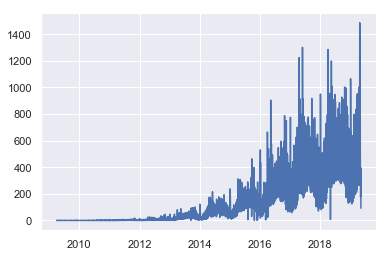

In [11]:
plt.plot(data_new)

### Look at stationarity
Most time-series models assume that the underlying time-series data is stationary. This assumption gives us some nice statistical properties that allows us to use various models for forecasting.

#### Stationarity is a statistical assumption that a time-series has:

Constant mean

Constant variance

Autocovariance does not depend on time

More simply put, if we are using past data to predict future data, we should assume that the data will follow the same general trends and patterns as in the past. This general statement holds for most training data and modeling tasks.

There are some good diagrams and explanations on stationarity here and here.

Sometimes we need to transform the data in order to make it stationary. However, this transformation then calls into question if this data is truly stationary and is suited to be modeled using these techniques.

##### Looking at our data:

Rolling mean and standard deviation look like they change over time. There may be some de-trending and removing seasonality involved. 

#### So for formal stationarity test we use:

1) Plotting Rolling Statistics

2) Dickey Fuller Test

In [12]:
Rolling_mean= data_new['ts'].rolling(window=12).mean()
Rolling_std=data_new['ts'].rolling(window=12).std()

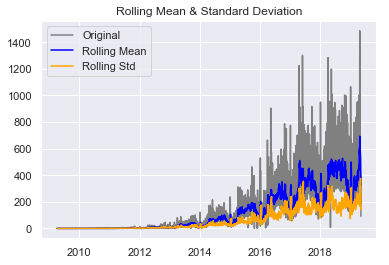

Test Statistic                   -1.658067
p-value                           0.452837
#Lags Used                       29.000000
Number of Observations Used    3660.000000
Critical Value (1%)              -3.432138
Critical Value (5%)              -2.862330
Critical Value (10%)             -2.567191
dtype: float64


In [13]:
org=plt.plot(data_new['ts'],color='grey',label='Original')
mean=plt.plot(Rolling_mean,color='blue',label='Rolling Mean')
std=plt.plot(Rolling_std,color='orange',label='Rolling Std')

plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)


from statsmodels.tsa.stattools import adfuller

fuller_test=adfuller(data_new['ts'])
dfoutput = pd.Series(fuller_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in fuller_test[4].items():
        dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

#### So the P_value is not significant and Null hypothesis is accepted i.e Series is not stationay

Lets understand what is making a TS non-stationary. There are 2 major reasons behind non-stationaruty of a TS:

1. Trend – varying mean over time. For eg, in this case we saw that on average, the number of passengers was growing over time.

2. Seasonality – variations at specific time-frames. eg people might have a tendency to buy cars in a particular month because of pay increment or festivals.

The underlying principle is to model or estimate the trend and seasonality in the series and remove those from the series to get a stationary series. Then statistical forecasting techniques can be implemented on this series. The final step would be to convert the forecasted values into the original scale by applying trend and seasonality constraints back

#### Transformation

Examples. Log, square root, etc.
We are going to look at log.
#### Smoothing

Examples. Weekly average, monthly average, rolling averages.
We are going to look at weekly average
#### Differencing

Examples. First-order differencing.
We are going to look at first-order differencing.
#### Polynomial Fitting

Examples. Fit a regression model.
#### Decomposition
Examples. from statsmodels.tsa.seasonal seasonal_decompose

In [14]:
data_new['ts_log']=data_new['ts'].apply(lambda x: np.log(x))
data_new['ts_moving_avg']=data_new['ts'].rolling(window=7).mean()     ### The greater the window the more smoothed the series
data_new['ts_diff']=data_new['ts'].diff()
data_new['ts_log_movng_avg']=data_new['ts_log'].rolling(window=7).mean()
data_new['ts_log_diff']=data_new['ts_log'].diff()
data_new['ts_moving_avg_diff']=data_new['ts_moving_avg'].diff()


C:\Users\ACER M5\Anaconda3\lib\site-packages\pandas\core\algorithms.py:1819: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


In [15]:
data_new_transformed=data_new.dropna()

In [16]:
data_new_transformed['ts_log_ewm'] = data_new_transformed['ts_log'].ewm(halflife = 7,
                                                                         ignore_na = False,
                                                                         min_periods = 0,
                                                                         adjust = True).mean()

C:\Users\ACER M5\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [17]:
data_new_transformed.tail()

,ts,ts_log,ts_moving_avg,ts_diff,ts_log_movng_avg,ts_log_diff,ts_moving_avg_diff,ts_log_ewm
date,,,,,,,,
2019-05-02,178.0,5.181784,367.142857,-111.0,5.820950,-0.484643,-29.000000,6.021962
2019-05-03,227.0,5.424950,343.571429,49.0,5.742906,0.243166,-23.571429,5.965678
2019-05-04,227.0,5.424950,338.714286,0.0,5.722967,0.000000,-4.857143,5.914700
2019-05-05,395.0,5.978886,293.000000,168.0,5.638196,0.553936,-45.714286,5.920751
2019-05-06,92.0,4.521789,245.714286,-303.0,5.420255,-1.457097,-47.285714,5.788862


In [18]:
data_new_transformed['ts_log_ewm']=data_new_transformed['ts_log']-data_new_transformed['ts_log_ewm']

C:\Users\ACER M5\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [19]:
def Plot_Data (df,ts,ts_transformed):
    df[ts].plot(color='green')
    df[ts_transformed].plot(color='blue')
    plt.legend([ts,ts_transformed])
    plt.show()
    plt.close()
    return

def Fuller_Test(df,ts):
    fuller_test=adfuller(df[ts])
    dfoutput = pd.Series(fuller_test[0:4], index=['Test Statistic for {0}'.format(ts),'p-value','#Lags Used','Number of Observations Used'])
    for key,value in fuller_test[4].items():
        dfoutput['Critical Value (%s)'%key] = value 
    print (dfoutput)
    return

def Original_Comparison(df,ts):  
    Rolling_mean= df[ts].rolling(window=12).mean()
    Rolling_std=df[ts].rolling(window=12).std()
    original=plt.plot(df[ts],color='grey',label='Original')
    mean=plt.plot(Rolling_mean,color='blue',label='Rolling Mean')
    std=plt.plot(Rolling_std,color='orange',label='Rolling Std')
    plt.legend(loc='best')
    plt.show()
    return
    

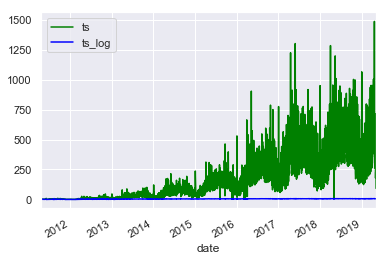

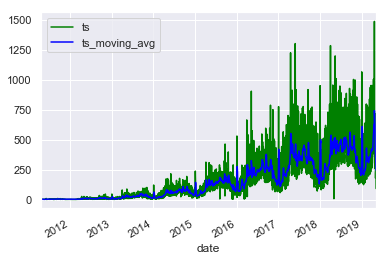

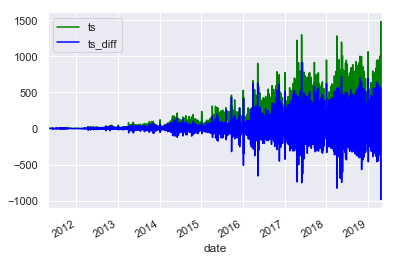

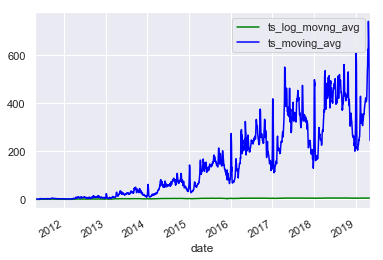

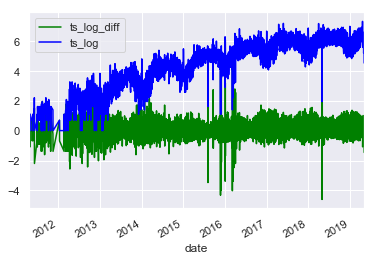

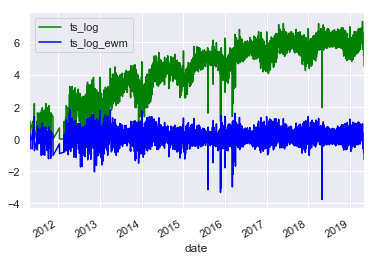

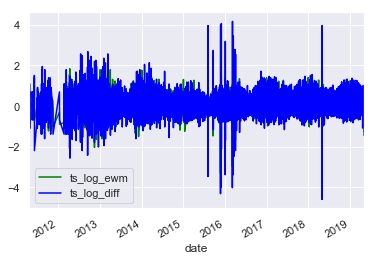

In [20]:
Plot_Data(data_new_transformed,'ts','ts_log')

Plot_Data(data_new_transformed,'ts','ts_moving_avg')

Plot_Data(data_new_transformed,'ts','ts_diff')

Plot_Data(data_new_transformed,'ts_log_movng_avg','ts_moving_avg')

Plot_Data(data_new_transformed,'ts_log_diff','ts_log')

Plot_Data(data_new_transformed,'ts_log','ts_log_ewm')

Plot_Data(data_new_transformed,'ts_log_ewm','ts_log_diff')

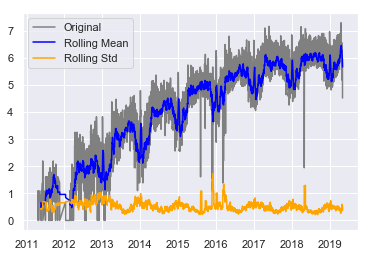

Test Statistic for ts_log        -2.110824
p-value                           0.240185
#Lags Used                       27.000000
Number of Observations Used    2666.000000
Critical Value (1%)              -3.432805
Critical Value (5%)              -2.862625
Critical Value (10%)             -2.567347
dtype: float64


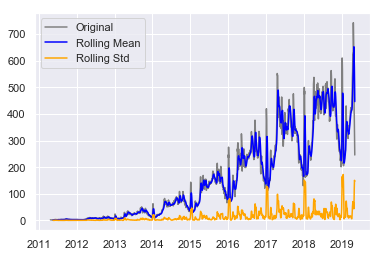

Test Statistic for ts_moving_avg      -1.181255
p-value                                0.681607
#Lags Used                            28.000000
Number of Observations Used         2665.000000
Critical Value (1%)                   -3.432806
Critical Value (5%)                   -2.862625
Critical Value (10%)                  -2.567348
dtype: float64


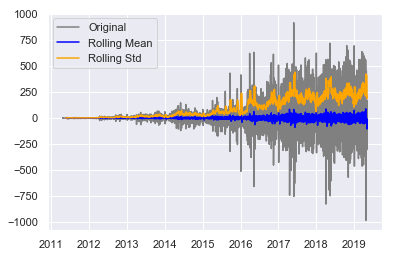

Test Statistic for ts_diff    -1.329246e+01
p-value                        7.316431e-25
#Lags Used                     2.800000e+01
Number of Observations Used    2.665000e+03
Critical Value (1%)           -3.432806e+00
Critical Value (5%)           -2.862625e+00
Critical Value (10%)          -2.567348e+00
dtype: float64


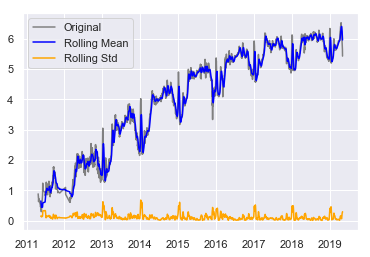

Test Statistic for ts_log_movng_avg      -2.097672
p-value                                   0.245452
#Lags Used                               28.000000
Number of Observations Used            2665.000000
Critical Value (1%)                      -3.432806
Critical Value (5%)                      -2.862625
Critical Value (10%)                     -2.567348
dtype: float64


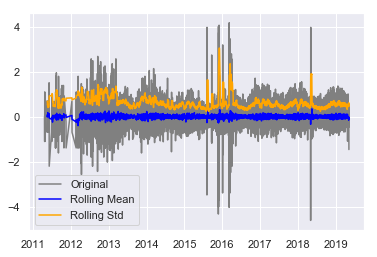

Test Statistic for ts_log_diff   -1.511005e+01
p-value                           7.719603e-28
#Lags Used                        2.600000e+01
Number of Observations Used       2.667000e+03
Critical Value (1%)              -3.432804e+00
Critical Value (5%)              -2.862624e+00
Critical Value (10%)             -2.567347e+00
dtype: float64


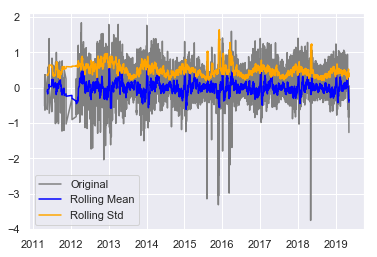

Test Statistic for ts_log_ewm   -9.954415e+00
p-value                          2.465831e-17
#Lags Used                       2.700000e+01
Number of Observations Used      2.666000e+03
Critical Value (1%)             -3.432805e+00
Critical Value (5%)             -2.862625e+00
Critical Value (10%)            -2.567347e+00
dtype: float64


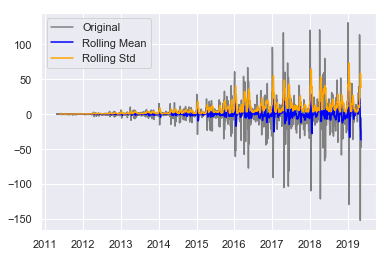

Test Statistic for ts_moving_avg_diff   -1.393928e+01
p-value                                  4.925467e-26
#Lags Used                               2.800000e+01
Number of Observations Used              2.665000e+03
Critical Value (1%)                     -3.432806e+00
Critical Value (5%)                     -2.862625e+00
Critical Value (10%)                    -2.567348e+00
dtype: float64


In [21]:
Original_Comparison(data_new_transformed,'ts_log')
Fuller_Test(data_new_transformed,'ts_log')

Original_Comparison(data_new_transformed,'ts_moving_avg')
Fuller_Test(data_new_transformed,'ts_moving_avg')

Original_Comparison(data_new_transformed,'ts_diff')
Fuller_Test(data_new_transformed,'ts_diff')

Original_Comparison(data_new_transformed,'ts_log_movng_avg')
Fuller_Test(data_new_transformed,'ts_log_movng_avg')

Original_Comparison(data_new_transformed,'ts_log_diff')
Fuller_Test(data_new_transformed,'ts_log_diff')

Original_Comparison(data_new_transformed,'ts_log_ewm')
Fuller_Test(data_new_transformed,'ts_log_ewm')

Original_Comparison(data_new_transformed,'ts_moving_avg_diff')
Fuller_Test(data_new_transformed,'ts_moving_avg_diff')

#### Here we applied Transformations of different kinds to de-trend our data and logarithmic weighted average (ts_log_ewm) has test statistic in the range of 99% percent confidence interval. Hence as the p-value is significant we reject the Null Hypothesis and this series is stationary.

Apart from log, moving average, differencing we have another method for de-trending and de-seasonality and  that is decomposition.

So for deomposition we shall use statsmodels api seaosnal_decompose


In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition=seasonal_decompose(data_new_transformed['ts_log'],freq=365)

data_new_transformed['trend']=decomposition.trend
data_new_transformed['seasonal']=decomposition.seasonal
data_new_transformed['residual']=decomposition.resid
data_new_transformed.dropna(inplace=True)

C:\Users\ACER M5\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\ACER M5\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\ACER M5\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.p

In [35]:
data_new_transformed.tail()

,ts,ts_log,ts_moving_avg,ts_diff,ts_log_movng_avg,ts_log_diff,ts_moving_avg_diff,ts_log_ewm,trend,seasonal,residual
date,,,,,,,,,,,
2018-11-01,282.0,5.641907,397.714286,8.0,5.905738,0.028779,-8.285714,-0.320869,5.879651,0.443268,-0.681012
2018-11-02,310.0,5.736572,391.428571,28.0,5.886777,0.094665,-6.285714,-0.204878,5.878327,0.132685,-0.274439
2018-11-03,345.0,5.843544,392.142857,35.0,5.888863,0.106972,0.714286,-0.088675,5.875432,0.045759,-0.077647
2018-11-04,997.0,6.904751,418.000000,652.0,5.917482,1.061206,25.857143,0.880844,5.875405,-0.068337,1.097683
2018-11-05,428.0,6.059123,413.285714,-569.0,5.906872,-0.845628,-4.714286,0.031897,5.869548,-0.137939,0.327514


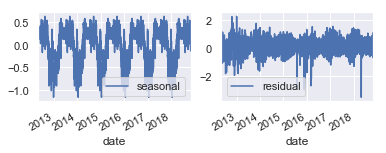

In [46]:
plt.subplot(111)
data_new_transformed['ts_log'].plot()
plt.legend(loc='best')
plt.subplot(112)
data_new_transformed['trend'].plot()
plt.legend(loc='best')
plt.subplot(223)
data_new_transformed['seasonal'].plot()
plt.legend(loc='best')
plt.subplot(224)
data_new_transformed['residual'].plot()
plt.legend(loc='best')
plt.show()

Here we can see that the trend, seasonality are separated out from data and we can model the residuals. Lets check stationarity of residuals:

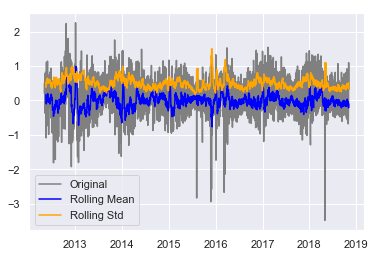

Test Statistic for residual   -7.776482e+00
p-value                        8.642067e-12
#Lags Used                     2.700000e+01
Number of Observations Used    2.302000e+03
Critical Value (1%)           -3.433194e+00
Critical Value (5%)           -2.862796e+00
Critical Value (10%)          -2.567439e+00
dtype: float64


In [37]:
Original_Comparison(data_new_transformed,'residual')
Fuller_Test(data_new_transformed,'residual')

#### So by viewing test statistic of all the above Dickey-Fuller tests we can see that transformation ts_log_ewm is the best with more than 99 % confidence of stationary Series. So we can now move on to modelling. 

#### Let us model some time-series data! Finally! ARIMA models.
We will be doing an example here! We can use ARIMA models when we know there is dependence between values and we can leverage that information to forecast.

ARIMA = Auto-Regressive Integrated Moving Average.
Assumptions. The time-series is stationary.
Depends on:
1. Number of AR (Auto-Regressive) terms (p).
2. Number of I (Integrated or Difference) terms (d).
3. Number of MA (Moving Average) terms (q).

#### ACF and PACF Plots
How do we determine p, d, and q? For p and q, we can use ACF and PACF plots (below).

Autocorrelation Function (ACF). Correlation between the time series with a lagged version of itself (e.g., correlation of Y(t) with Y(t-1)).

Partial Autocorrelation Function (PACF). Additional correlation explained by each successive lagged term.

How do we interpret ACF and PACF plots?

p – Lag value where the PACF chart crosses the upper confidence interval for the first time.

q – Lag value where the ACF chart crosses the upper confidence interval for the first time.

In [38]:
from statsmodels.tsa.stattools import acf, pacf

# determine ACF and PACF
lag_acf = acf(np.array(data_new_transformed['ts_log_ewm']), nlags = 20)
lag_pacf = pacf(np.array(data_new_transformed['ts_log_ewm']), nlags = 20)

# plot ACF and PACF
def plot_acf_pacf(df, ts):
  """
  Plot auto-correlation function (ACF) and partial auto-correlation (PACF) plots
  """
  f, (ax1, ax2) = plt.subplots(1,2, figsize = (10, 5)) 

  #Plot ACF: 

  ax1.plot(lag_acf)
  ax1.axhline(y=0,linestyle='--',color='gray')
  ax1.axhline(y=-1.96/np.sqrt(len(df[ts])),linestyle='--',color='gray')
  ax1.axhline(y=1.96/np.sqrt(len(df[ts])),linestyle='--',color='gray')
  ax1.set_title('Autocorrelation Function for %s' %(ts))

  #Plot PACF:
  ax2.plot(lag_pacf)
  ax2.axhline(y=0,linestyle='--',color='gray')
  ax2.axhline(y=-1.96/np.sqrt(len(df[ts])),linestyle='--',color='gray')
  ax2.axhline(y=1.96/np.sqrt(len(df[ts])),linestyle='--',color='gray')
  ax2.set_title('Partial Autocorrelation Function for %s' %(ts))
  
  plt.tight_layout()
  plt.show()
  plt.close()
  
  return

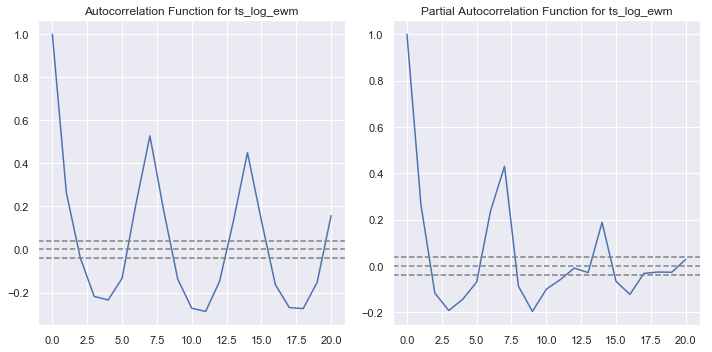

In [39]:
plot_acf_pacf(data_new_transformed,'ts_log_ewm')

#### Hence p=1.8 and q=1.8

In [40]:
def run_arima_model(df, ts, p, d, q):
  """
  Run ARIMA model
  """
  from statsmodels.tsa.arima_model import ARIMA

  # fit ARIMA model on time series
  model = ARIMA(df[ts], order=(p, d, q))  
  results_ = model.fit(disp=-1)  
  
  # get lengths correct to calculate RSS
  len_results = len(results_.fittedvalues)
  ts_modified = df[ts][-len_results:]
  
  # calculate root mean square error (RMSE) and residual sum of squares (RSS)
  rss = sum((results_.fittedvalues - ts_modified)**2)
  rmse = np.sqrt(rss / len(df[ts]))
  
  # plot fit
  plt.plot(df[ts])
  plt.plot(results_.fittedvalues, color = 'red')
  plt.title('For ARIMA model (%i, %i, %i) for ts %s, RSS: %.4f, RMSE: %.4f' %(p, d, q, ts, rss, rmse))
  
  plt.show()
  plt.close()
  
  return results_

C:\Users\ACER M5\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


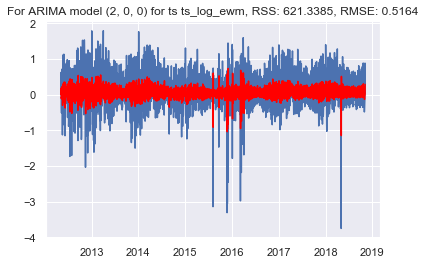

C:\Users\ACER M5\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


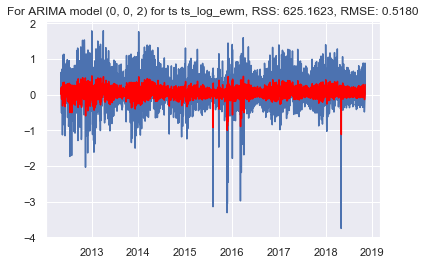

C:\Users\ACER M5\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


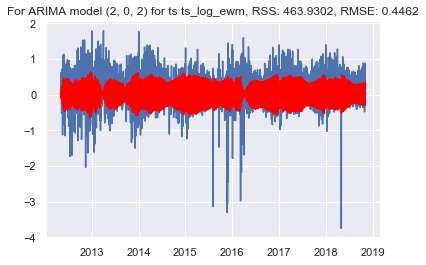

In [43]:
# Note: I do the differencing in the transformation of the data 'ts_log_ewm'
# AR model with 1st order differencing - ARIMA (p,d,q)
model_AR = run_arima_model(df = data_new_transformed, 
                           ts = 'ts_log_ewm', 
                           p = 2, 
                           d = 0, 
                           q = 0)

# MA model with 1st order differencing - ARIMA (0,0,1)
model_MA = run_arima_model(df = data_new_transformed, 
                           ts = 'ts_log_ewm', 
                           p = 0, 
                           d = 0, 
                           q = 2)

# ARMA model with 1st order differencing - ARIMA (1,0,1)
model_MA = run_arima_model(df = data_new_transformed, 
                           ts = 'ts_log_ewm', 
                           p = 2, 
                           d = 0, 
                           q = 2)

#### Hence the combined model is best with RMSE = 0.4462